# Cycling Data Science - Clusters

Data Science is a hot topic that is impacting a huge range of diverse areas from business to sport. With so many cyclists collecting and uploading their data, there is plenty of raw material upon which to draw interesting insights. This project takes a look at how we might explore a set of historic rides. As a possible objective it would be very helpful to be able to categorise rides automatically.

I took as a data set Garmin files covering 2014-2017 that I had uploaded to Golden Cheetah (GC). This excellent software calculates a large range of statistics and provides an excellent interface for exploring rides. In Preferences you can enable a restful web service api that will be available whilst GC is running. This provides URLs that you can call from external programmes to retrieve data. For some reason I could not make this work reliably using Python 3.5, so this notebook runs Python 2.7. A separate Python 3.5 notebook in this folder is used to download the Strava history. 

## Create a csv file with GC history from 2014-2017

It is straightforward to load summary statistics for my entire history of GC data into a pandas DataFrame. The list includes some runs that will need to be filtered out from cycling. The rides include races, training sessions (outdoors and on the turbo), social rides, long mountainous epics and some mountain biking. The challenge is to find ways to identify them. 

In [409]:
%matplotlib inline
import pandas as pd
import matplotlib.pylab as plt
import numpy as np


In [410]:
path = "http://localhost:12021/"
athlete = 'Gavin'
start = '2014/01/01'

data = pd.read_csv('{}{}?metadata=all&since={}'.format(path,athlete,start), skipinitialspace=True)


In [411]:
data.shape

(852, 364)

There are over 800 records since 2014. For each one Golden Cheetah has generated 364 built-in metrics and metadata https://github.com/GoldenCheetah/GoldenCheetah/wiki/API-Athlete-Metrics-and-Metadata. These include standard cycling measures like average speed, power and heart rate, as well as more esoteric metrics like "Time expended when Power is above CP and W' bal is between 50% and 75% of W'". Some of the metrics apply to other sports, such as running or swimming, so they are not relevant to bike rides. It is helpful to do a bit of tidying up. 

In [412]:
# Create DateTime column (note that GC 'time' does not always match start time of event)
data['DateTime'] = [pd.to_datetime(r.split('.')[0], format='%Y_%m_%d_%H_%M_%S') for r in data.filename]
data = data[np.roll(data.columns,1)]


In [413]:
# Filter out runs by looking for speed and (power or cadence)
data = data[data.Sport == 'Bike']

In [414]:
# Remove columns of NaNs
data = data.dropna(axis=1, how='all')
# Remove metrics that are all zeros or all the same
mask = [c for c in data.columns if (data[c].max() != data[c].min())]
data = data[mask]
# Remove HRV fields, Checksum and some metadata
data.drop(['date','Fraction_of_normal_RR_intervals', 'Average_of_all_NN_intervals',\
          'Standard_deviation_of_NN', 'SDANN', 'SDNNIDX', 'rMSSD', 'Rest_HR',\
          'Rest_AVNN', 'Rest_SDNN', 'Rest_rMSSD', 'HRV_Recovery_Points', 'Weight',\
          'RPE', 'Keywords', 'Objective', 'Notes', 'Device', 'Device_Info',\
          'Calendar_Text','Data','Checksum'], axis=1, inplace=True)
data.shape

(809, 215)

We now have the relevant fields for bike rides

In [415]:
data.head()

,DateTime,time,filename,axPower,aPower_Relative_Intensity,aBikeScore,Skiba_aVI,aPower_Response_Index,aNP,aIF,...,W2_W'bal_Moderate_Fatigue,W3_W'bal_Heavy_Fatigue,W4_W'bal_Severe_Fatigue,W1_W'bal_Work_Low_Fatigue,W2_W'bal_Work_Moderate_Fatigue,W3_W'bal_Work_Heavy_Fatigue,W4_W'bal_Work_Severe_Fatigue,Below_CP_Work,Workout_Code,Workout_Title
0,2014-01-05 08:24:27,10:24:27,2014_01_05_08_24_27.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0.000,0.000,0.000,0.000,0.000,NaN,NaN
1,2014-01-07 19:27:20,21:27:20,2014_01_07_19_27_20.json,253.686,0.90602,82.2699,1.09083,1.85520,256.653,0.91662,...,128,0,0,829.311,32.421,0.000,0.000,813.108,NaN,NaN
2,2014-01-11 08:46:58,10:46:58,2014_01_11_08_46_58.json,265.642,0.94872,235.9180,1.12208,2.21341,286.852,1.02447,...,2087,1565,3590,337.727,382.428,302.116,944.262,1635.620,NaN,NaN
3,2014-01-12 08:48:00,10:48:00,2014_01_12_08_48_00.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0.000,0.000,0.000,0.000,0.000,NaN,NaN
4,2014-01-14 19:11:46,21:11:46,2014_01_14_19_11_46.json,235.593,0.84140,70.8548,1.10010,1.67045,236.347,0.84410,...,0,0,0,781.467,0.000,0.000,0.000,770.513,NaN,NaN


In [416]:
data.to_csv('GC_Gavin_History.csv')

## Merge GC data and with strava metadata

In [417]:
data = pd.read_csv('GC_Gavin_History.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data.DateTime = pd.to_datetime(data.DateTime)
data.head()

,DateTime,time,filename,axPower,aPower_Relative_Intensity,aBikeScore,Skiba_aVI,aPower_Response_Index,aNP,aIF,...,W2_W'bal_Moderate_Fatigue,W3_W'bal_Heavy_Fatigue,W4_W'bal_Severe_Fatigue,W1_W'bal_Work_Low_Fatigue,W2_W'bal_Work_Moderate_Fatigue,W3_W'bal_Work_Heavy_Fatigue,W4_W'bal_Work_Severe_Fatigue,Below_CP_Work,Workout_Code,Workout_Title
0,2014-01-05 08:24:27,10:24:27,2014_01_05_08_24_27.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0.000,0.000,0.000,0.000,0.000,NaN,NaN
1,2014-01-07 19:27:20,21:27:20,2014_01_07_19_27_20.json,253.686,0.90602,82.2699,1.09083,1.85520,256.653,0.91662,...,128,0,0,829.311,32.421,0.000,0.000,813.108,NaN,NaN
2,2014-01-11 08:46:58,10:46:58,2014_01_11_08_46_58.json,265.642,0.94872,235.9180,1.12208,2.21341,286.852,1.02447,...,2087,1565,3590,337.727,382.428,302.116,944.262,1635.620,NaN,NaN
3,2014-01-12 08:48:00,10:48:00,2014_01_12_08_48_00.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0.000,0.000,0.000,0.000,0.000,NaN,NaN
4,2014-01-14 19:11:46,21:11:46,2014_01_14_19_11_46.json,235.593,0.84140,70.8548,1.10010,1.67045,236.347,0.84410,...,0,0,0,781.467,0.000,0.000,0.000,770.513,NaN,NaN


In [418]:
strava = pd.read_csv('strava.csv')
strava.DateTime = pd.to_datetime(strava.DateTime)
strava = strava[strava.Sport == 'Ride']
strava.head()

,DateTime,Name,Sport,Trainer,Distance,Workout_Type,Type
0,2014-01-05 08:24:28,Windsor Ride,Ride,False,92.3972,NaN,Ride
1,2014-01-07 19:27:21,Turbo intervals,Ride,True,36.3350,NaN,Trainer
3,2014-01-11 08:46:59,"11/01/2014 Richmond, Greater London, United Ki...",Ride,False,68.0642,NaN,Ride
4,2014-01-12 08:48:01,Surrey Hills with Jamie,Ride,False,105.7190,NaN,Ride
5,2014-01-14 19:11:47,Turbo 2x20mins,Ride,True,34.8615,NaN,Trainer


These strava times were adjusted manually to match the (wrong) GC times. Sort of the wrong way around really.

In [419]:
fix = [['2015-08-04 19:14:04','2015-08-04 20:14:04'],['2016-07-16 13:12:00','2016-07-16 13:11:00'],\
       ['2016-10-07 09:06:14','2016-10-07 08:06:14'],['2014-09-01 10:32:35','2014-09-04 09:32:00'],\
       ['2014-09-02 08:00:41','2014-09-02 07:00:00'],['2014-09-03 07:30:59','2014-09-03 06:30:00'],\
       ['2014-09-04 07:59:41','2014-09-04 06:59:00'],['2014-09-05 11:18:40','2014-09-05 10:18:00'],\
       ['2014-09-05 12:57:55','2014-09-05 11:57:00'],['2014-09-06 07:30:49','2014-09-06 06:30:00'],\
       ['2014-09-07 08:30:59','2014-09-06 07:30:00'],['2016-04-04 10:31:13','2016-04-04 09:31:00'],\
       ['2015-08-16 05:48:03','2015-08-16 06:48:00'],['2015-08-02 10:31:03','2015-08-02 11:31:00'],\
       ['22/02/14 13:38:27','22/02/14 12:38'],['23/02/14 10:34:03','23/02/14 09:34'],\
       ['24/02/14 10:35:10','24/02/14 09:35'],['25/02/14 10:39:39','25/02/14 09:39'],\
       ['26/02/14 10:40:23','26/02/14 09:40'],['27/02/14 10:04:15','27/02/14 09:04'],\
       ['28/02/14 10:05:23','28/02/14 09:05'],['01/03/14 10:23:10','01/03/14 09:23'],\
       ['02/03/14 10:10:30','02/03/14 09:10'],['26/11/2016 08:39:00','26/11/2016 08:38:00'],\
       ['02/08/2015 10:34:03','02/08/2015 11:34:03']]
for f in fix:
    strava.loc[strava.DateTime == f[0],'DateTime'] = pd.to_datetime(f[1])

Since GC and Strava start times may not match exactly to the second, create a column called DTM that rounds to the DateTime nearest minute to permit a join.

In [420]:
data['DTM'] = data.DateTime.values.astype('datetime64[m]')
strava['DTM'] = strava.DateTime.values.astype('datetime64[m]')
data = pd.merge(data,strava[['DTM','Name', 'Distance', 'Type']], on='DTM', how='left', suffixes=('','_strava'))


Quick check that GC and Strava distances match for the majority of rides.

,Name,DateTime,Distance,Distance_strava
278,Ride over for lunch,2015-12-28 11:21:03,79.4311,44.1723
298,Hillingdon E12 - rolled in with bunch,2016-01-30 14:23:27,17.4634,51.7228
626,Bletchingley,2017-04-23 10:08:36,109.0660,96.8266


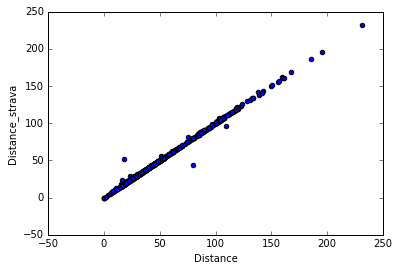

In [421]:
data.plot.scatter('Distance','Distance_strava')
data[abs(data.Distance-data.Distance_strava)>10][['Name','DateTime','Distance','Distance_strava']]


In [422]:
data.to_csv('Gavin_History_Names.csv')

## APV
Attempt to recalculate Average_Power_Variance '2015_06_13_16_12_53.json' value was 194.137

In [445]:
lastActivity = '2015_06_13_16_12_53.json'
athlete = 'Gavin'
activity = pd.read_csv(path+'/'+athlete+'/activity/'+lastActivity+'?format=csv',skipinitialspace=True)


In [449]:
w = activity.watts.rolling(30).mean()
(activity.watts - w).std()

203.59132722622022